# **MODELLING**

#### Train Logistic Regression and Random Forest. Compute precision, recall, F1, ROC-AUC, and create SHAP plots.
#### Train XGBoost and LightGBM with imbalance handling (SMOTE/undersampling/class-weights). Compare recall vs baselines.

In [1076]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1077]:
df = pd.read_csv("../data/Nova_Features_Eng.csv")

# Print the top 5 rows
df.head()

,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,fee_ratio,amount_velocity_interaction,device_ip_risk,new_device_velocity,amount_usd_capped,log_amount_usd,log_fee,new_device_high_velocity,young_account_high_amount,ip_location_risk
0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.468549+00:00,US,USD,CAD,ATM,278.19,278.19,4.25,...,0.015277,0.0,0.064206,0,278.19,5.631893,1.658228,0,0,0
1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38.468549+00:00,CA,CAD,MXN,WEB,208.51,154.29,4.24,...,0.027481,0.0,0.270275,0,154.29,5.045294,1.656321,0,0,0
2,fc855034-3ea5-4993-9afa-b511d93fe5e8,6d0d9b27-fa26-45f8-93b1-2df29d182d9c,2022-10-03 23:02:43.468549+00:00,US,USD,CNY,MOBILE,160.33,160.33,2.70,...,0.016840,0.0,0.410343,0,160.33,5.083452,1.308333,0,0,0
3,2cf8c08e-42ec-444d-a755-34b9a2a0a4ca,7bd5200c-5d19-44f0-9afe-8b339a05366b,2022-10-04 01:08:53.468549+00:00,US,USD,EUR,MOBILE,59.41,59.41,2.22,...,0.037367,0.0,0.327294,0,59.41,4.101155,1.169381,0,0,0
4,d907a74d-b426-438d-97eb-dbe911aca91c,70a93d26-8e3a-4179-900c-a4a7a74d08e5,2022-10-04 09:35:03.468549+00:00,US,USD,INR,MOBILE,200.96,200.96,3.61,...,0.017964,0.0,0.108174,0,200.96,5.308070,1.528228,0,0,0


In [1078]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11137 entries, 0 to 11136
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   transaction_id               11137 non-null  object 
 1   customer_id                  11137 non-null  object 
 2   timestamp                    11137 non-null  object 
 3   home_country                 11137 non-null  object 
 4   source_currency              11137 non-null  object 
 5   dest_currency                11137 non-null  object 
 6   channel                      11137 non-null  object 
 7   amount_src                   11137 non-null  float64
 8   amount_usd                   11137 non-null  float64
 9   fee                          11137 non-null  float64
 10  exchange_rate_src_to_dest    11137 non-null  float64
 11  device_id                    11137 non-null  object 
 12  new_device                   11137 non-null  int64  
 13  ip_address      

## Encoding

#### Categorical variables will be one-hot encoded to preserve interpretability and avoid target leakage, given manageable cardinality and dataset size.

In [1080]:
# Drop columns that should NOT be encoded
df.drop(columns=['transaction_id','customer_id', 'device_id', 'log_amount_usd', 'day_of_week', 'hour', 'log_fee', 'ip_address', 'timestamp', 'amount_src', 'exchange_rate_src_to_dest'], inplace=True)

#### Label Encoder

In [1082]:
from sklearn.preprocessing import LabelEncoder

In [1083]:
# Initialize the encoder

encoder = LabelEncoder()

In [1084]:
categorical_cols = [
    "home_country", "source_currency", "dest_currency", "channel",
    "kyc_tier", "ip_country", "currency_pair", "time_of_day"
]


for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col].astype(str))


## Data Splitting

#### Splitting the cleaned dataset into training and testing sets, ensuring the target variable's distribution is represented in both.

In [1086]:
# Separate the features and target

X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

In [1087]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [1088]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Selection

#### Training multiple classification models to find the best one for predicting fraud detection. Start with a baseline and expand to more advance models.

In [1090]:
# Import model libraries

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [1091]:
fraud_weight = 3
class_weight = {0: 1.0, 1: fraud_weight}

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight=class_weight
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight=class_weight,
        random_state=42
    ),

    # Gradient Boosting does NOT support class_weight directly
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ),

    # AdaBoost also uses sample_weight instead of class_weight
    "AdaBoost": AdaBoostClassifier(
        n_estimators=200,
        learning_rate=0.8,
        random_state=42
    ),

    "Decision Tree": DecisionTreeClassifier(
        max_depth=None,
        min_samples_leaf=1,
        class_weight=class_weight,
        random_state=42
    ),

    "SVC": SVC(
        probability=True,
        class_weight=class_weight,
        random_state=42
    ),

    # KNN has no class_weight parameter
    "KNN": KNeighborsClassifier(
        n_neighbors=7,
        weights="distance"
    ),

    # XGBoost uses scale_pos_weight (VERY IMPORTANT)
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=fraud_weight,  
        eval_metric="logloss",
        random_state=42
    )
}


In [1092]:
results = {}

for name, model in models.items():

    # Train on scaled data for all models
    model.fit(X_train_scaled, y_train)

    # Predict probabilities
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Predict labels (use your tuned threshold if needed)
    y_pred = model.predict(X_test_scaled)

    # Store results
    results[name] = {
        "y_pred": y_pred,
        "y_prob": y_prob
    }


In [1093]:
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)



================ Logistic Regression ================
Classification Report:
              precision    recall  f1-score   support

           0     0.9825    0.9951    0.9887      2029
           1     0.9422    0.8191    0.8763       199

    accuracy                         0.9794      2228
   macro avg     0.9623    0.9071    0.9325      2228
weighted avg     0.9789    0.9794    0.9787      2228

ROC-AUC: 0.942


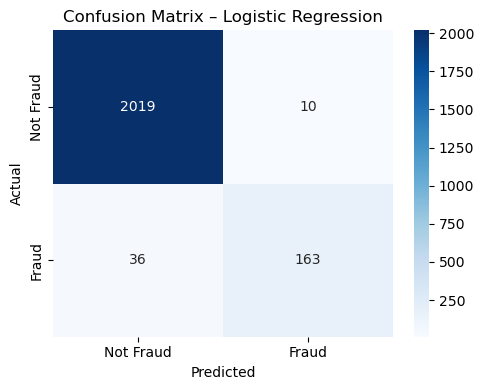

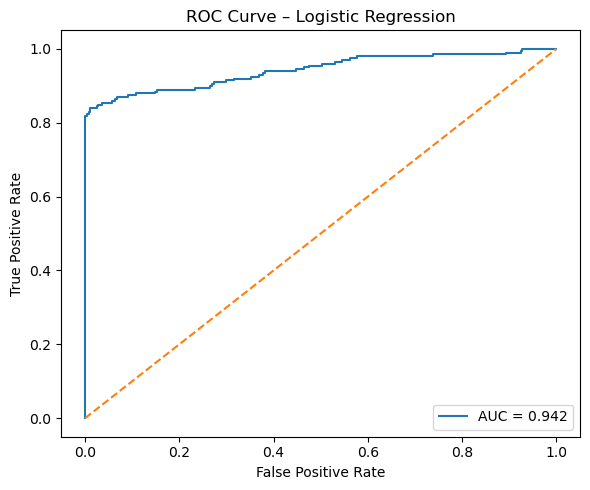


================ Random Forest ================
Classification Report:
              precision    recall  f1-score   support

           0     0.9826    1.0000    0.9912      2029
           1     1.0000    0.8191    0.9006       199

    accuracy                         0.9838      2228
   macro avg     0.9913    0.9095    0.9459      2228
weighted avg     0.9841    0.9838    0.9831      2228

ROC-AUC: 0.9448


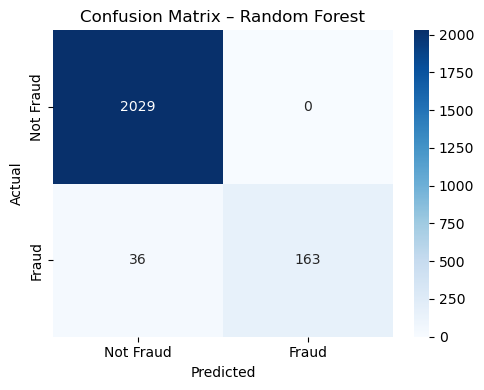

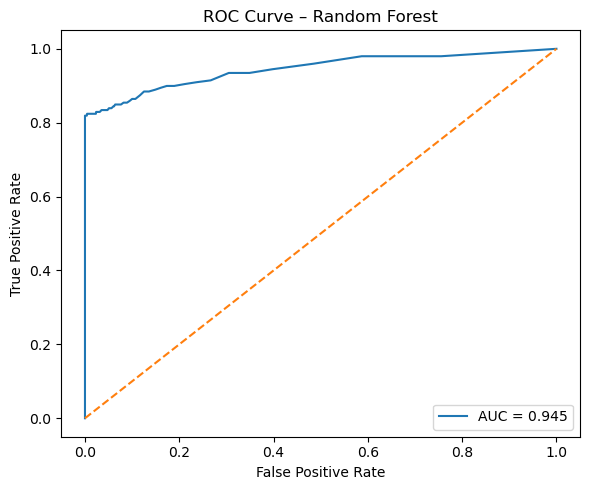


================ Gradient Boosting ================
Classification Report:
              precision    recall  f1-score   support

           0     0.9825    0.9951    0.9887      2029
           1     0.9422    0.8191    0.8763       199

    accuracy                         0.9794      2228
   macro avg     0.9623    0.9071    0.9325      2228
weighted avg     0.9789    0.9794    0.9787      2228

ROC-AUC: 0.9468


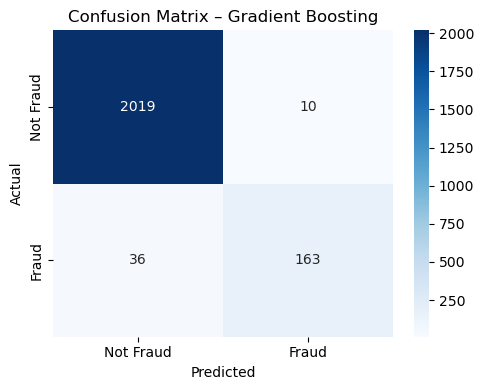

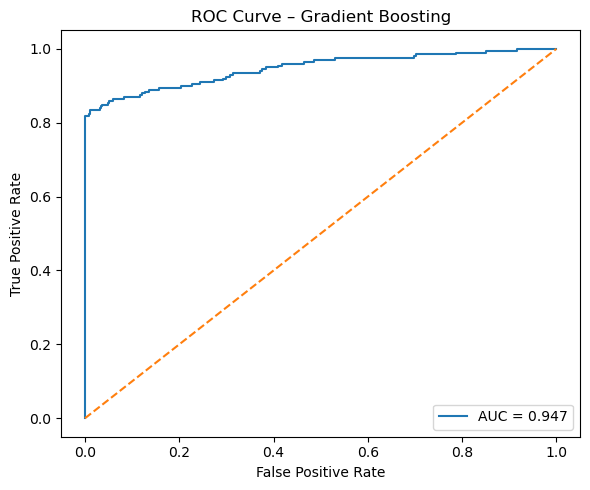


================ AdaBoost ================
Classification Report:
              precision    recall  f1-score   support

           0     0.9825    0.9985    0.9905      2029
           1     0.9819    0.8191    0.8932       199

    accuracy                         0.9825      2228
   macro avg     0.9822    0.9088    0.9418      2228
weighted avg     0.9825    0.9825    0.9818      2228

ROC-AUC: 0.9325


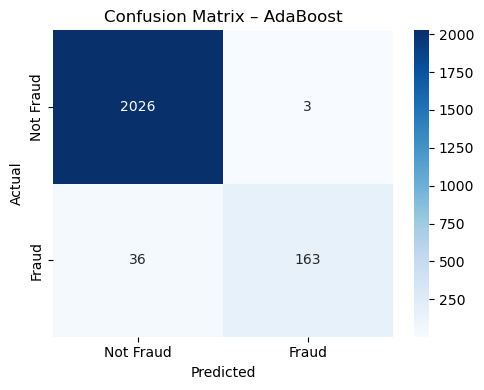

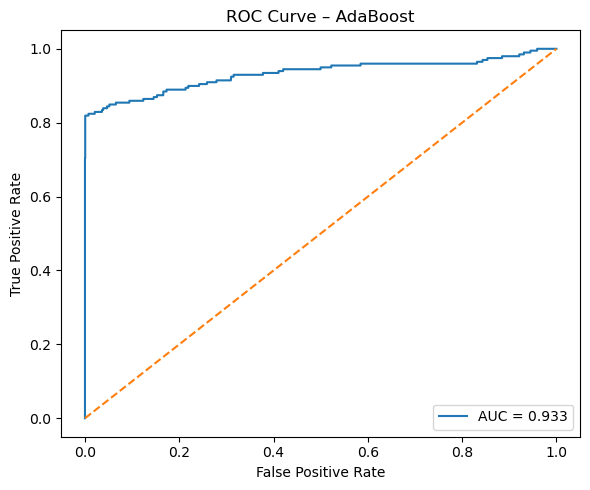


================ Decision Tree ================
Classification Report:
              precision    recall  f1-score   support

           0     0.9851    0.9754    0.9802      2029
           1     0.7717    0.8492    0.8086       199

    accuracy                         0.9641      2228
   macro avg     0.8784    0.9123    0.8944      2228
weighted avg     0.9660    0.9641    0.9649      2228

ROC-AUC: 0.9123


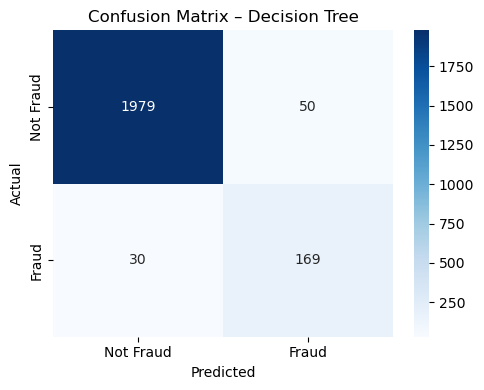

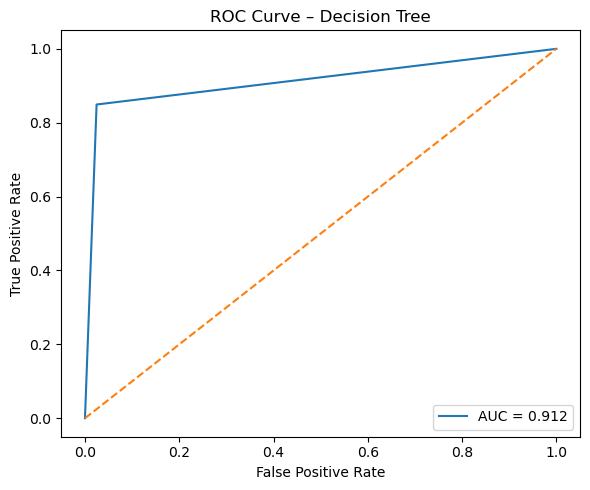


================ SVC ================
Classification Report:
              precision    recall  f1-score   support

           0     0.9826    0.9995    0.9910      2029
           1     0.9939    0.8191    0.8981       199

    accuracy                         0.9834      2228
   macro avg     0.9882    0.9093    0.9445      2228
weighted avg     0.9836    0.9834    0.9827      2228

ROC-AUC: 0.9235


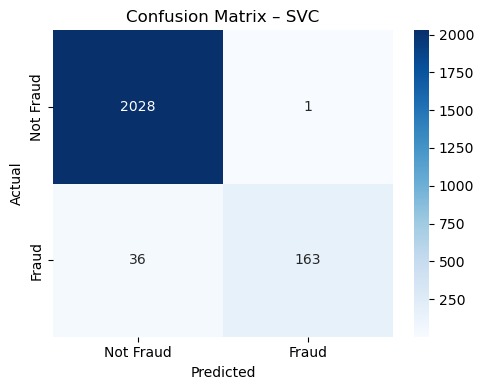

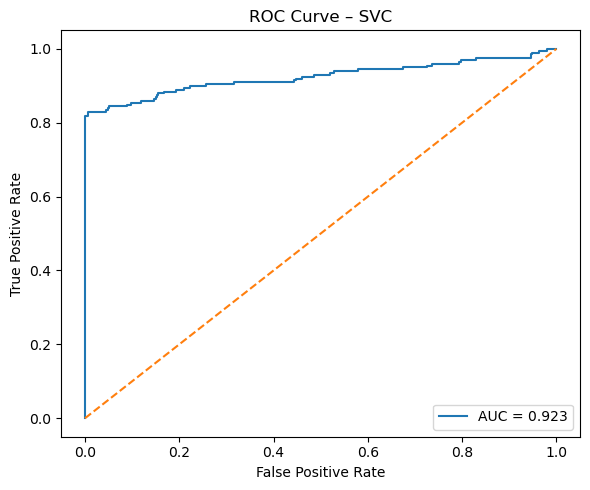


================ KNN ================
Classification Report:
              precision    recall  f1-score   support

           0     0.9830    0.9966    0.9897      2029
           1     0.9591    0.8241    0.8865       199

    accuracy                         0.9811      2228
   macro avg     0.9710    0.9103    0.9381      2228
weighted avg     0.9808    0.9811    0.9805      2228

ROC-AUC: 0.9164


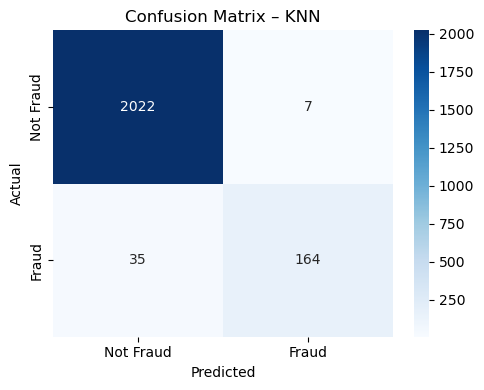

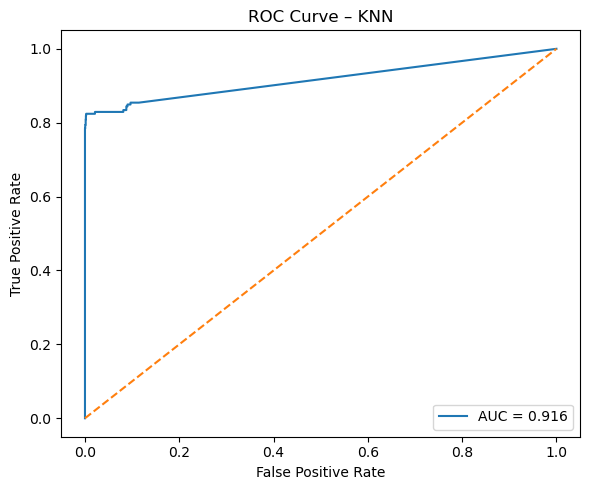


================ XGBoost ================
Classification Report:
              precision    recall  f1-score   support

           0     0.9825    0.9966    0.9895      2029
           1     0.9588    0.8191    0.8835       199

    accuracy                         0.9807      2228
   macro avg     0.9707    0.9078    0.9365      2228
weighted avg     0.9804    0.9807    0.9800      2228

ROC-AUC: 0.9382


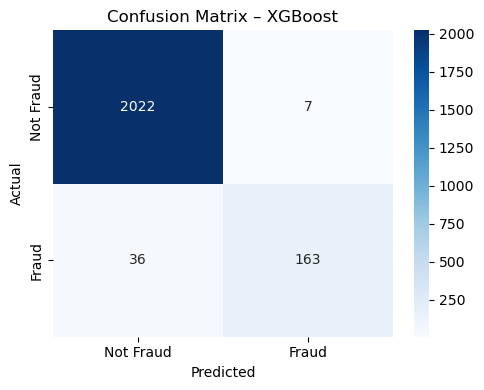

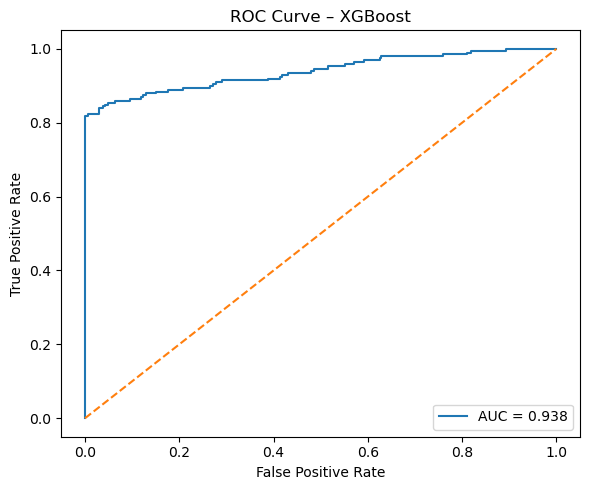

In [1094]:
for name, res in results.items():

    print(f"\n================ {name} ================")

    # ----- Classification Report -----
    print("Classification Report:")
    print(
        classification_report(
            y_test,
            res['y_pred'],
            digits=4
        )
    )

    # ----- ROC-AUC -----
    auc = roc_auc_score(y_test, res['y_prob'])
    print("ROC-AUC:", round(auc, 4))

    # ----- Confusion Matrix -----
    cm = confusion_matrix(y_test, res['y_pred'])

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Not Fraud', 'Fraud'],
        yticklabels=['Not Fraud', 'Fraud']
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix – {name}')
    plt.tight_layout()
    plt.show()

    # ----- ROC Curve -----
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve – {name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


In [1141]:
# Check all model to select the best performing model

comparison = []

for name, res in results.items():

    y_pred = res['y_pred']
    y_prob = res['y_prob']

    auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    comparison.append({
        "Model": name,
        "ROC_AUC": round(auc, 4),
        "Precision (Fraud)": round(precision, 4),
        "Recall (Fraud)": round(recall, 4),
        "F1 (Fraud)": round(f1, 4),
        "Fraud_Captured": tp,
        "Fraud_Missed": fn,
        "False_Positives": fp
    })

comparison_df = pd.DataFrame(comparison).sort_values(
    by=["Precision (Fraud)", "Recall (Fraud)", "ROC_AUC"],
    ascending=[False, False, False]
)

comparison_df


,Model,ROC_AUC,Precision (Fraud),Recall (Fraud),F1 (Fraud),Fraud_Captured,Fraud_Missed,False_Positives
1,Random Forest,0.9448,1.0000,0.8191,0.9006,163,36,0
5,SVC,0.9235,0.9939,0.8191,0.8981,163,36,1
3,AdaBoost,0.9325,0.9819,0.8191,0.8932,163,36,3
6,KNN,0.9164,0.9591,0.8241,0.8865,164,35,7
7,XGBoost,0.9382,0.9588,0.8191,0.8835,163,36,7
2,Gradient Boosting,0.9468,0.9422,0.8191,0.8763,163,36,10
0,Logistic Regression,0.9420,0.9422,0.8191,0.8763,163,36,10
4,Decision Tree,0.9123,0.7717,0.8492,0.8086,169,30,50


### Feature Importance (Random Forest)

In [1136]:
# Get feature importance (numeric + categorical already encoded)

# Get trained Random Forest model
rf = models["Random Forest"]

# Feature importance
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# Show top features
print(feature_importance.head(15))


amount_velocity_interaction    0.118362
txn_velocity_1h                0.117807
txn_velocity_24h               0.104490
velocity_ratio                 0.089332
ip_risk_score                  0.084222
risk_score_internal            0.082615
device_trust_score             0.041128
ip_location_risk               0.037734
account_age_days               0.035794
fee                            0.030185
amount_usd_capped              0.028938
amount_usd                     0.028729
device_ip_risk                 0.026561
fee_ratio                      0.024913
new_device_high_velocity       0.024540
dtype: float64


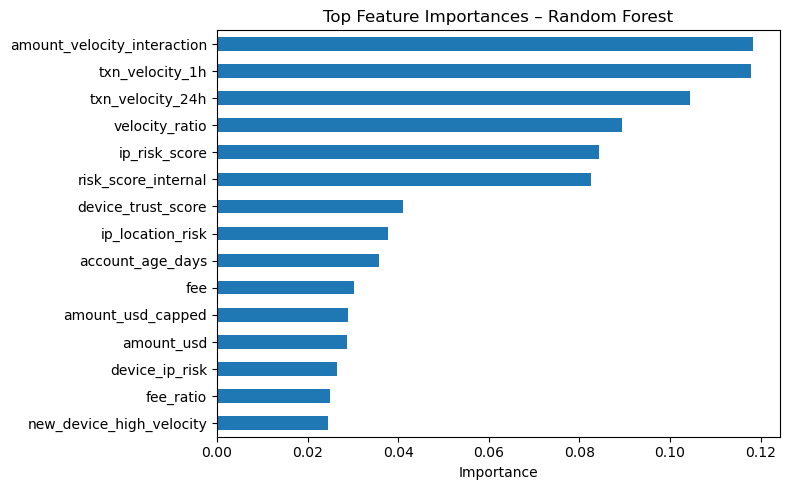

In [1134]:
# Plot top 15 feature importances 

top_n = 15

plt.figure(figsize=(8, 5))
feature_importance.head(top_n).sort_values().plot(
    kind='barh'
)
plt.title('Top Feature Importances – Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## Final Dataset is ready

#### Save the dataset

In [1144]:
import joblib

best_model = models["Random Forest"]  # already trained

joblib.dump(best_model, "random_forest_fraud_model.pkl")


['random_forest_fraud_model.pkl']

In [1146]:
feature_columns = pd.DataFrame({
    "feature_name": X_train.columns
})

feature_columns.to_csv(
    "random_forest_feature_columns.csv",
    index=False
)
